# MPII Human Pose

Original paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.638.2045&rep=rep1&type=pdf

## Y
The Y-value has the following structure: $10000\times 14 \times 3$. 
The data contains $14$ joint locations with the following order:
* Right ankle
* Right knee
* Right hip
* Left hip
* Left knee
* Left ankle
* Right wrist
* Right elbow
* Right shoulder
* Left shoulder
* Left elbow
* Left wrist
* Neck
* Head top

Each joint has $3$ values:
* X value
* Y value
* visiblity (1=True, 0=False)

In [1]:
%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak import datasets
from pak import utils
import matplotlib.pyplot as plt

root = '/home/julian/Data/pak_test1'

mpii = datasets.MPII_human_pose(root)


from scipy.io import loadmat
from scipy.ndimage import imread

mat = mpii.root_export + "/mpii_human_pose_v1_u12_1.mat"

data = mpii.get_annotation()

/home/julian/Data/pak_test1/mpii_human_pose_v1_u12_2 found :)
/home/julian/Data/pak_test1/mpii_human_pose_v1_u12_2/images found :)
stuff 0
(array([[(array(['037454012.jpg'],
      dtype='<U13'),)]],
      dtype=[('name', 'O')]), array([[ (array([[ 3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]],
      dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [2]:
%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak import datasets
from pak import utils
import matplotlib.pyplot as plt

root = '/home/julian/Data/pak_test1'

mpii = datasets.MPII_human_pose(root)


from scipy.io import loadmat
from scipy.ndimage import imread

mat = mpii.root_export + "/mpii_human_pose_v1_u12_1.mat"
print(mat)

M_ = loadmat(mat)


# X, Y = mpii.get_raw()

# fig = plt.figure(figsize=(16,8))
# ax = fig.add_subplot(111)
# x = X[0].astype('int32')
# gray = (x[:,:,0] + x[:,:,1] + x[:,:,2]) / (255*3)
# ax.imshow(gray, cmap='gray')
# y = Y[0]
# for x,y,v in y:
#     if v > 0:
#         ax.scatter(x, y, s=600)

def nbr_to_joint(i):
    if i == 0:
        return "r ankle"
    elif i == 1:
        return "r knee"
    elif i == 2:
        return "r hip"
    elif i == 3:
        return "l hip"
    elif i == 4:
        return "l knee"
    elif i == 5:
        return "l ankle"
    elif i == 6:
        return "pelvis"
    elif i == 7:
        return "thorax"
    elif i == 8:
        return "upper neck"
    elif i == 9:
        return "head top"
    elif i == 10:
        return "r wrist"
    elif i == 11:
        return "r elbow"
    elif i == 12:
        return "r shoulder"
    elif i == 13:
        return "l shoulder"
    elif i == 14:
        return "l elbow"
    elif i == 15:
        return "l wrist"
    else:
        raise Exception("Invalid joint id:" + str(i))

/home/julian/Data/pak_test1/mpii_human_pose_v1_u12_2 found :)
/home/julian/Data/pak_test1/mpii_human_pose_v1_u12_2/images found :)
/home/julian/Data/pak_test1/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat


In [30]:
import numpy as np
TR = M['img_train']
TR = TR[0][0][0]
print(TR.shape, np.sum(TR))

(24987,) 18079


In [38]:
M = M_['RELEASE']

AL = M['annolist']
TR = M['img_train']
TR = TR[0][0][0]

current_id = 0
e = AL[0][0][0][current_id]
e_is_training = TR[current_id] == 1

class ImageMetaData:
    vidx = -1
    frame_sec = -1
    name = None
    people = []
    
    def __str__(self):
        return "vidx:" + str(self.vidx) + \
            ", frame_sec:" + str(self.frame_sec) + \
            ", name:" + self.name

class Person:
    head_bb = None
    joints = None

def test_if_joints_are_first(joints):
    for F, _, _, _ in joints:
        if F > 15:
            return False
        else:
            return True
        
def compress_joints(joints):
    obj = []
    if not test_if_joints_are_first(joints):
        for x, y,joint_type, visible in joints:
            joint_type = joint_type[0][0]
            x = x[0][0]
            y = y[0][0]
            visible = int(visible[0]) if len(visible) == 1 else -1
            obj.append((joint_type, x, y, visible))
        return obj
    else:
        for joint_type, x, y, visible in joints:
            joint_type = joint_type[0][0]
            x = x[0][0]
            y = y[0][0]
            visible = int(visible[0]) if len(visible) == 1 else -1
            obj.append((joint_type, x, y, visible))
        return obj

def get_data(image_meta, is_training_data):
    """ the meta data has a horrible shape..
        I guess that's because of the extraction
        from matlab code..
    """
    
    result = ImageMetaData()
    
    result.name= image_meta[0][0][0][0][0]
    _, nbr_persons = image_meta[1].shape

    if is_training_data:
        result.vidx = image_meta[2][0][0]
        result.frame_sec = image_meta[3][0][0]
        
    #if len(image_meta[2][0]) > 0:
    #    result.vidx = image_meta[2][0][0]
    #if len(image_meta[3][0]) > 0:
    #    result.frame_sec = image_meta[3][0][0]
    
    for person in range(nbr_persons):
        p = Person()
        if is_training_data:
            x1 = image_meta[1][0][person][0][0][0]
            y1 = image_meta[1][0][person][1][0][0]
            x2 = image_meta[1][0][person][2][0][0]
            y2 = image_meta[1][0][person][3][0][0]
            p.head_bb = ((x1, y1), (x2, y2))
    
            joints = image_meta[1][0][person][4][0][0][0][0]
            p.joints = compress_joints(joints)
            result.people.append(p)
        else:
            print(image_meta)
    
    return result


result = get_data(e, e_is_training)

print(result)

# name= e[0][0][0][0][0]
# _, nbr_persons = e[1].shape
# print('number of people:', nbr_persons)

# vidx = e[2][0][0]
# frame_sec = e[3][0][0]
# print("vidx:" + str(vidx) + ", frame_sec:" + str(frame_sec))

# person = 0

# x1 = e[1][0][person][0][0][0]
# y1 = e[1][0][person][1][0][0]
# x2 = e[1][0][person][2][0][0]
# y2 = e[1][0][person][3][0][0]

# print("(bb):", ((x1, y1), (x2, y2)))

# joints = e[1][0][person][4][0][0][0][0]
# #print(joints)


# obj = compress_joints(joints)

# ax = plot_img(name,obj)

# ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1])

(array([[(array(['037454012.jpg'],
      dtype='<U13'),)]],
      dtype=[('name', 'O')]), array([[ (array([[ 3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
      dtype=[('x', 'O'), ('y', 'O')]))]],
      dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64))
vidx:-1, frame_sec:-1, name:037454012.jpg


#people 3


/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


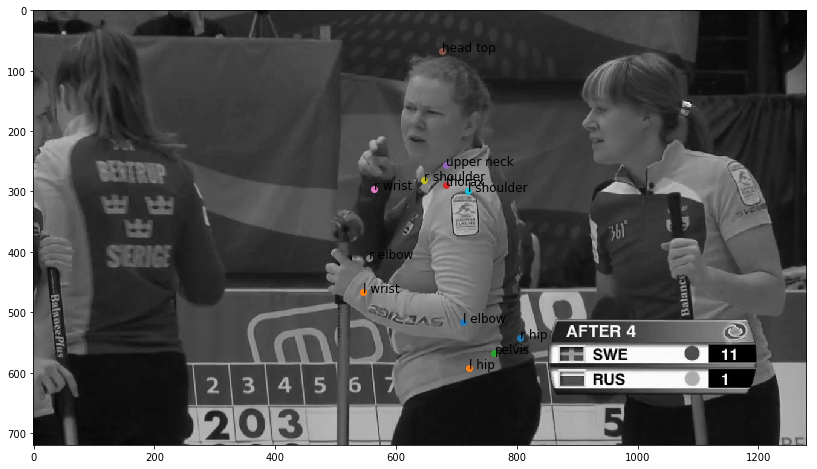

In [36]:
M = M_['RELEASE']

AL = M['annolist']

e = AL[0][0][0][5]
name= e[0][0][0][0][0]

_, nbr_persons = e[1].shape

print('#people', nbr_persons)

a = e[1][0][0][0][0][0]
b = e[1][0][0][1][0][0]
c = e[1][0][0][2][0][0]

    
    #print(e[1][0][0][0])
a1 = e[1][0][0][0] # uint16
a2 = e[1][0][0][1] # uint8

b1 = e[1][0][0][2] # uint16
b2 = e[1][0][0][3] # uint8

#c = e[1][0][0][4]
c = e[1][0][1][4]

person_elem = e[1][0][0][4]


def extract_figure(elem):
    elem = elem[0][0][0][0]

    obj = []
    for joint_type, x, y, visible in elem:
        joint_type = joint_type[0][0]
        x = x[0][0]
        y = y[0][0]
        visible = int(visible[0]) if len(visible) == 1 else -1
        obj.append((joint_type, x, y, visible))
    return obj

obj = extract_figure(person_elem)


def plot_img(name, obj=None):
    img_path = mpii.root_export + '/images/' + name
    img = imread(img_path)
    img = img.astype('int32')
    I = (img[:,:,0] + img[:,:,1] + img[:,:,2])/(255*3)

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    ax.imshow(I, cmap='gray')

    if obj is not None:
        for joint,x,y,visible in obj:
            text = nbr_to_joint(joint)
            ax.scatter([x], [y])
            ax.text(x, y, text, fontsize=12)

        #ax.scatter([a1],[b1])

    return ax

plot_img(name, obj)